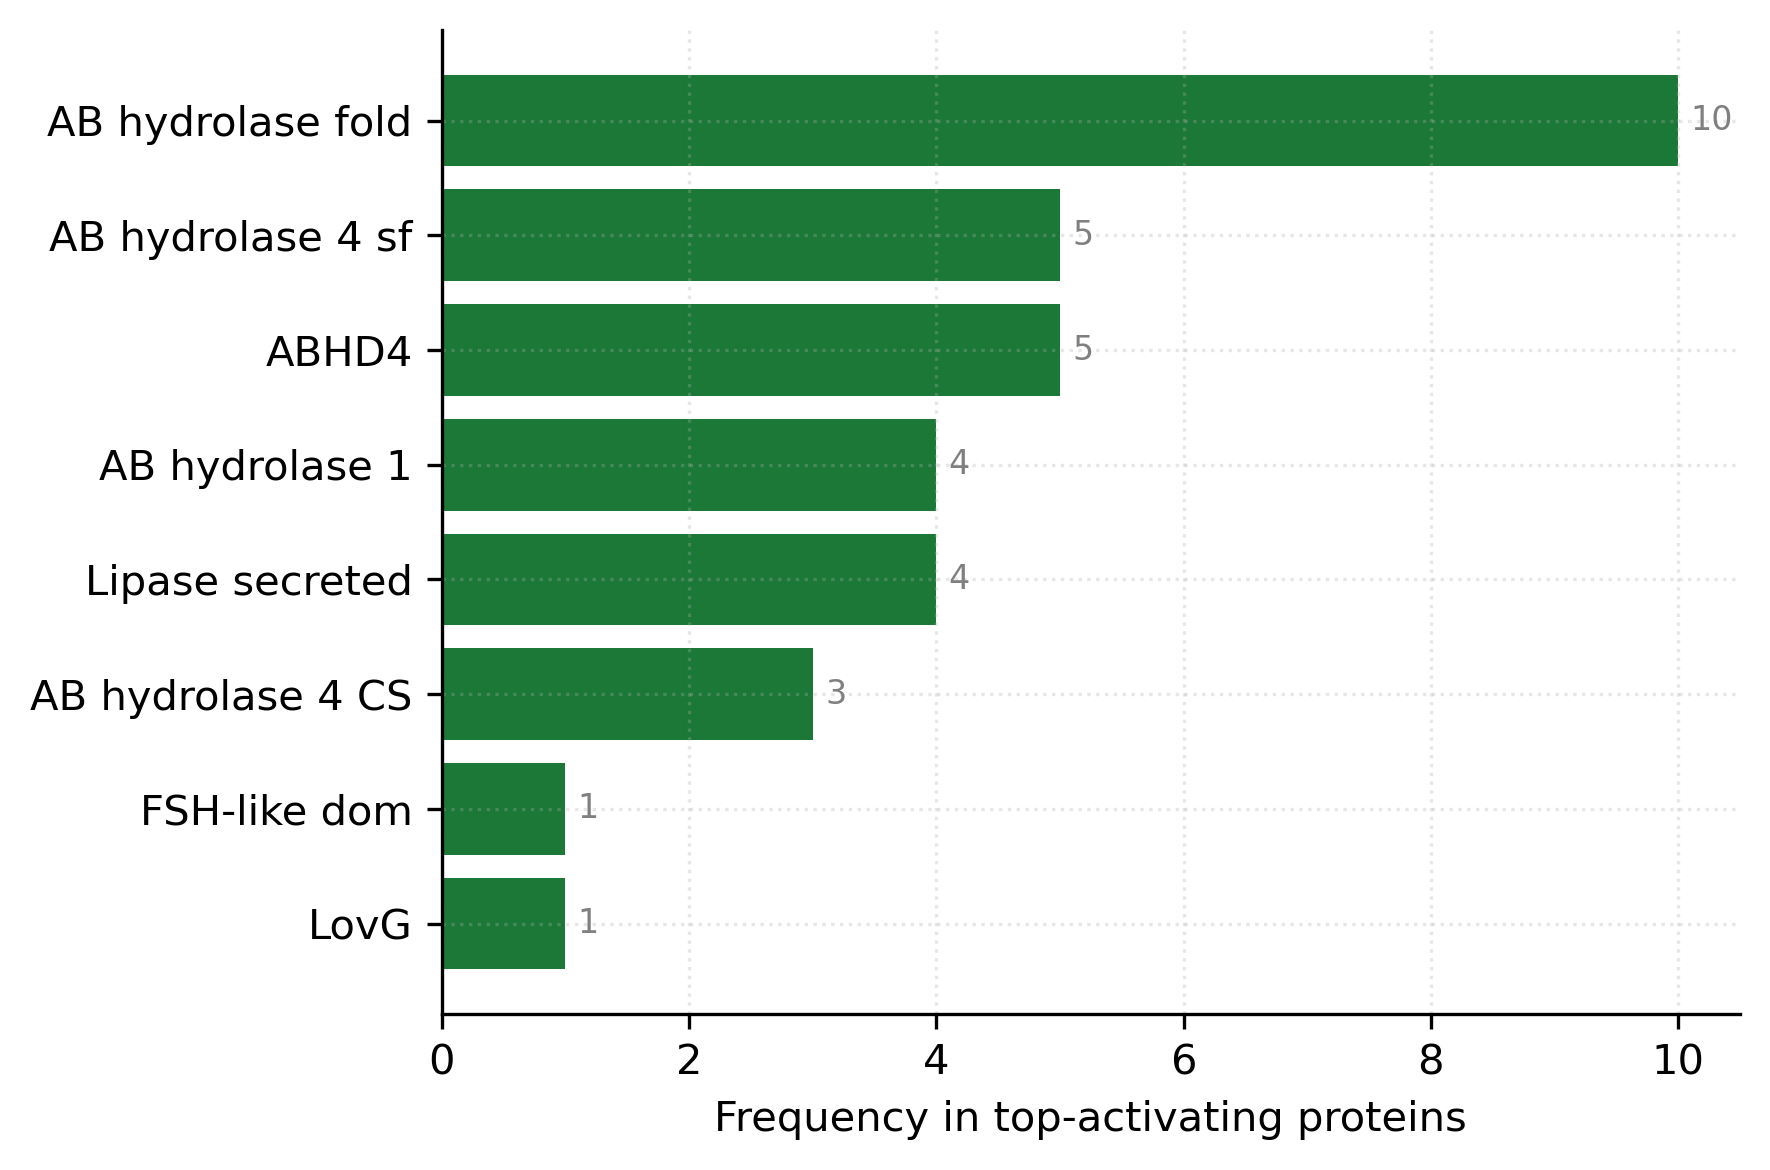

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
from textwrap import dedent
import re

# ---------- raw text from the user -----------------
raw = dedent("""
Q24093
IPR000073AB_hydrolase_1
IPR000952AB_hydrolase_4_CS
IPR050960AB_hydrolase_4_sf
IPR029058AB_hydrolase_fold
IPR012020ABHD4

S5ZJC7
IPR029058AB_hydrolase_fold
IPR005152Lipase_secreted

Q5F2F2
IPR050960AB_hydrolase_4_sf
IPR029058AB_hydrolase_fold
IPR012020ABHD4

Q40863
IPR000073AB_hydrolase_1
IPR000952AB_hydrolase_4_CS
IPR050960AB_hydrolase_4_sf
IPR029058AB_hydrolase_fold
IPR012020ABHD4

Q802V6
IPR000073AB_hydrolase_1
IPR050960AB_hydrolase_4_sf
IPR029058AB_hydrolase_fold
IPR012020ABHD4


P45524
IPR000073AB_hydrolase_1
IPR000952AB_hydrolase_4_CS
IPR050960AB_hydrolase_4_sf
IPR029058AB_hydrolase_fold
IPR012020ABHD4

D4AX63
IPR029058AB_hydrolase_fold
IPR005152Lipase_secreted

D9N4H3
IPR029058AB_hydrolase_fold
IPR005152Lipase_secreted

A0A084B9Z4
IPR029058AB_hydrolase_fold
IPR005152Lipase_secreted

W7MWX7
IPR029058AB_hydrolase_fold
IPR005645FSH-like_dom
IPR050593LovG
""").strip().splitlines()

# ---------- parse all InterPro annotations -----------
domain_counts = {}

for line in raw:
    if line.startswith("IPR"):
        # split at the first non-digit character after the 6‑digit IPR code
        match = re.match(r"IPR\d{6}(.*)", line)
        if match:
            domain_name = match.group(1)
            # remove leading/trailing underscores, convert to spaces for readability
            domain_name_clean = domain_name.strip("_").replace("_", " ")
            domain_counts[domain_name_clean] = domain_counts.get(domain_name_clean, 0) + 1

# ---------- build dataframe for plotting -------------
df = pd.DataFrame(
    sorted(domain_counts.items(), key=lambda x: x[1], reverse=True),
    columns=["Domain", "Count"]
)

# ---------- plot -------------------------------------
plt.figure(figsize=(6, 4), dpi=300)
plt.barh(df["Domain"], df["Count"], color="#1b7837")
plt.gca().invert_yaxis()
plt.xlabel("Frequency in top‑activating proteins")
# plt.title("InterPro annotations among top‑10 protein\nLayer 12, 2112", y = 0.95)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
for idx, (cnt) in enumerate(df["Count"]):
    plt.text(cnt + 0.1, idx, str(cnt), va="center", fontsize=8, color="gray")

plt.tight_layout()

# Save in high resolution
import os
os.makedirs("../results", exist_ok=True)

# Save as PNG with high DPI
plt.savefig("../results/l12_2112_top10_domain_histogram.png", 
           dpi=300, bbox_inches='tight', facecolor='white')

# Save as PDF (vector format)
plt.savefig("../results/l12_2112_top10_domain_histogram.pdf", 
           bbox_inches='tight', facecolor='white')

plt.show()


In [2]:
import sys

sys.path.append('../plm_circuits')

# Import utility functions
from helpers.utils import (
    clear_memory,
    load_esm,
    load_sae_prot,
    mask_flanks_segment,
    patching_metric,
    cleanup_cuda
)

import helpers.protein_viz_utils as viz

import torch
import numpy as np
import json
from functools import partial

In IPython
Set autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
In IPython
Set autoreload


In [3]:

# Setup device and load models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load ESM-2 model
esm_transformer, batch_converter, esm2_alphabet = load_esm(33, device=device)

# Load SAEs for multiple layers
main_layers = [4, 8, 12, 16, 20, 24, 28]
saes = []
for layer in main_layers:
    sae_model = load_sae_prot(ESM_DIM=1280, SAE_DIM=4096, LAYER=layer, device=device)
    saes.append(sae_model)

layer_2_saelayer = {layer: layer_idx for layer_idx, layer in enumerate(main_layers)}

Using device: cuda


In [4]:

# Load sequence data and define protein parameters
with open('../data/full_seq_dict.json', "r") as json_file:
    seq_dict = json.load(json_file)

# Define protein-specific parameters
sse_dict = {"2B61A": [[182, 316]], "1PVGA": [[101, 202]]}
fl_dict = {"2B61A": [44, 43], "1PVGA": [65, 63]}

# Choose protein for analysis
protein = "2B61A"
seq = seq_dict[protein]
position = sse_dict[protein][0]

# Define segment boundaries
ss1_start = position[0] - 5 
ss1_end = position[0] + 5 + 1 
ss2_start = position[1] - 5 
ss2_end = position[1] + 5 + 1 

print(f"Analyzing protein: {protein}")
print(f"Sequence length: {len(seq)}")
print(f"Segment 1: {ss1_start}-{ss1_end}")
print(f"Segment 2: {ss2_start}-{ss2_end}")

Analyzing protein: 2B61A
Sequence length: 377
Segment 1: 177-188
Segment 2: 311-322


In [5]:
# Prepare full sequence and get baseline contact predictions
full_seq_L = [(1, seq)]
_, _, batch_tokens_BL = batch_converter(full_seq_L)
batch_tokens_BL = batch_tokens_BL.to(device)
batch_mask_BL = (batch_tokens_BL != esm2_alphabet.padding_idx).to(device)

with torch.no_grad():
    full_seq_contact_LL = esm_transformer.predict_contacts(batch_tokens_BL, batch_mask_BL)[0]

# Prepare clean sequence (with optimal flanks)
clean_fl = fl_dict[protein][0]
L = len(seq)
left_start = max(0, ss1_start - clean_fl)
left_end = ss1_start
right_start = ss2_end
right_end = min(L, ss2_end + clean_fl)
unmask_left_idxs = list(range(left_start, left_end))
unmask_right_idxs = list(range(right_start, right_end))

clean_seq_L = mask_flanks_segment(seq, ss1_start, ss1_end, ss2_start, ss2_end, unmask_left_idxs, unmask_right_idxs)
_, _, clean_batch_tokens_BL = batch_converter([(1, clean_seq_L)])
clean_batch_tokens_BL = clean_batch_tokens_BL.to(device)
clean_batch_mask_BL = (clean_batch_tokens_BL != esm2_alphabet.padding_idx).to(device)

with torch.no_grad():
    clean_seq_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]

print(f"Clean flank size: {clean_fl}")
print(f"Clean sequence contact recovery: {patching_metric(clean_seq_contact_LL, full_seq_contact_LL, ss1_start, ss1_end, ss2_start, ss2_end):.4f}")

# Prepare corrupted sequence (with suboptimal flanks)
corr_fl = fl_dict[protein][1]
left_start = max(0, ss1_start - corr_fl)
left_end = ss1_start
right_start = ss2_end
right_end = min(L, ss2_end + corr_fl)
unmask_left_idxs = list(range(left_start, left_end))
unmask_right_idxs = list(range(right_start, right_end))

corr_seq_L = mask_flanks_segment(seq, ss1_start, ss1_end, ss2_start, ss2_end, unmask_left_idxs, unmask_right_idxs)
_, _, corr_batch_tokens_BL = batch_converter([(1, corr_seq_L)])
corr_batch_tokens_BL = corr_batch_tokens_BL.to(device)
corr_batch_mask_BL = (corr_batch_tokens_BL != esm2_alphabet.padding_idx).to(device)

with torch.no_grad():
    corr_seq_contact_LL = esm_transformer.predict_contacts(corr_batch_tokens_BL, corr_batch_mask_BL)[0]

print(f"Corrupted flank size: {corr_fl}")
print(f"Corrupted sequence contact recovery: {patching_metric(corr_seq_contact_LL, full_seq_contact_LL, ss1_start, ss1_end, ss2_start, ss2_end):.4f}")

# Create patching metric function
_patching_metric = partial(
    patching_metric,
    orig_contact=full_seq_contact_LL,
    ss1_start=ss1_start,
    ss1_end=ss1_end,
    ss2_start=ss2_start,
    ss2_end=ss2_end,
)

Clean flank size: 44
Clean sequence contact recovery: 0.5738
Corrupted flank size: 43
Corrupted sequence contact recovery: 0.0279


In [6]:
# Import hook classes
from hook_manager import SAEHookProt

print("Creating layer-wise caches for performance analysis...")

clean_layer_caches = {}
corr_layer_caches = {}
clean_layer_errors = {}
corr_layer_errors = {}

for layer_idx in main_layers:
    sae_model = saes[layer_2_saelayer[layer_idx]]
    
    # Clean caches
    hook = SAEHookProt(sae=sae_model, mask_BL=clean_batch_mask_BL, cache_latents=True, 
                       layer_is_lm=False, calc_error=True, use_error=True)
    handle = esm_transformer.esm.encoder.layer[layer_idx].register_forward_hook(hook)
    with torch.no_grad():
        clean_seq_sae_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
    cleanup_cuda()
    handle.remove()
    print(f"Layer {layer_idx}, clean score: {_patching_metric(clean_seq_sae_contact_LL):.4f}")
    clean_layer_caches[layer_idx] = sae_model.feature_acts
    clean_layer_errors[layer_idx] = sae_model.error_term
    # print shapes
    print(clean_layer_caches[layer_idx].shape, clean_layer_errors[layer_idx].shape)

    # Corrupted caches
    hook = SAEHookProt(sae=sae_model, mask_BL=corr_batch_mask_BL, cache_latents=True, 
                       layer_is_lm=False, calc_error=True, use_error=True)
    handle = esm_transformer.esm.encoder.layer[layer_idx].register_forward_hook(hook)
    with torch.no_grad():
        corr_seq_sae_contact_LL = esm_transformer.predict_contacts(corr_batch_tokens_BL, corr_batch_mask_BL)[0]
    cleanup_cuda()
    handle.remove()
    print(f"Layer {layer_idx}, corr score: {_patching_metric(corr_seq_sae_contact_LL):.4f}")
    corr_layer_caches[layer_idx] = sae_model.feature_acts
    corr_layer_errors[layer_idx] = sae_model.error_term

print("Layer-wise caches created successfully!")

Creating layer-wise caches for performance analysis...
Layer 4, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 4, corr score: 0.0279
Layer 8, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 8, corr score: 0.0279
Layer 12, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 12, corr score: 0.0279
Layer 16, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 16, corr score: 0.0279
Layer 20, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 20, corr score: 0.0279
Layer 24, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 24, corr score: 0.0279
Layer 28, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 28, corr score: 0.0279
Layer-wise caches created successfully!


In [7]:
clean_layer_caches[4][:, 3788].shape

torch.Size([379])

In [8]:
clean_layer_caches[4][:, 3788] - corr_layer_caches[4][:, 3788] > 0.3

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

In [9]:
clean_topk = sae_model.topK_activation(clean_layer_caches[4], k=sae_model.k).cpu().numpy()
corr_topk = sae_model.topK_activation(corr_layer_caches[4], k=sae_model.k).cpu().numpy()

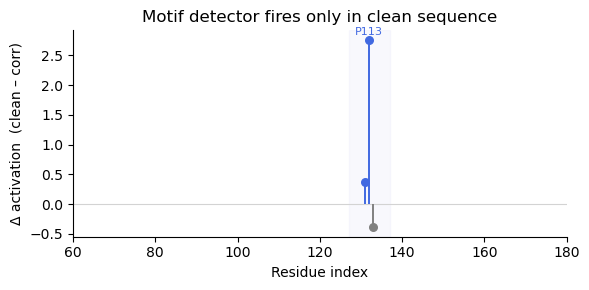

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1.  Pull the activations out of your caches
# -------------------------------------------------
# clean_layer_caches[4] :  [seq_len, n_neurons]
# neuron index you’re showcasing = 3788
clean = clean_layer_caches[4][:, 3788].cpu().numpy() #clean_topk[:, 3788]  #sae_model.topK_activation(clean_layer_caches[4][:, 3788], k=sae_model.k).cpu().numpy()
corr  =  corr_layer_caches[4][:, 3788].cpu().numpy() #sae_model.topK_activation(corr_layer_caches[4][:, 3788], k=sae_model.k).cpu().numpy()
delta = clean - corr                     # Δ activation

# -------------------------------------------------
# 2.  Choose which residues to plot
# -------------------------------------------------
# Either: keep every position whose |Δ| exceeds a fixed threshold …
threshold = 0.30
mask = np.abs(delta) > threshold

# … or, if you prefer: show only the top-k largest changes
# k = 40
# idx_topk = np.argsort(-np.abs(delta))[:k]
# mask = np.zeros_like(delta, dtype=bool)
# mask[idx_topk] = True

x = np.arange(len(delta))[mask]
y = delta[mask]

# -------------------------------------------------
# 3.  Plot lollipops
# -------------------------------------------------
motif_pos = 132        # residue position of the motif centre (0-based; change if needed)

fig, ax = plt.subplots(figsize=(6, 3))
ax.hlines(0, 0, len(delta), color="lightgray", linewidth=0.8, zorder=1)

for xi, yi in zip(x, y):
    color = "royalblue" if yi > 0 else "gray"
    ax.vlines(xi, 0, yi, color=color, linewidth=1.4, zorder=2)
    ax.scatter(xi, yi, color=color, s=30, zorder=3)

# -------------------------------------------------
# 4.  Highlight the motif residue/window
# -------------------------------------------------
ax.axvspan(motif_pos - 5, motif_pos + 5, color="lavender", alpha=0.25, zorder=0)
ax.text(motif_pos, delta[motif_pos] + 0.05*np.sign(delta[motif_pos]),
        "P113", ha="center", va="bottom", fontsize=8, color="royalblue")

# -------------------------------------------------
# 5.  Aesthetics
# -------------------------------------------------
ax.set_xlim(60, 180 ) #len(delta)-1)
ax.set_xlabel("Residue index")
ax.set_ylabel("Δ activation  (clean – corr)")
ax.set_title("Motif detector fires only in clean sequence")
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.show()


In [11]:
index_delta = 132 - 113


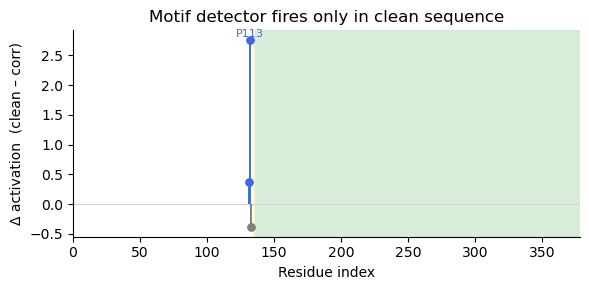

In [ ]:
flank_start = 116 + index_delta         # first residue that is always un-masked
motif_pos   = 113 + index_delta         # the causal motif centre

fig, ax = plt.subplots(figsize=(6, 3))

# baseline
ax.hlines(0, 0, len(delta)-1, color="lightgray", lw=0.8, zorder=1)

# lollipops (same as before)
for xi, yi in zip(x, y):
    col = "royalblue" if yi > 0 else "gray"
    ax.vlines(xi, 0, yi, color=col, lw=1.4, zorder=2)
    ax.scatter(xi, yi, color=col, s=28, zorder=3)

# 1️⃣ shade the always-unmasked flank (light mint-green)
ax.axvspan(flank_start, len(delta)-1, color="#c8e6c9", alpha=0.7, zorder=0)
# ax.text(flank_start + 2, ax.get_ylim()[1]*0.95,
#         "Flank un-masked\nin both inputs",
#         fontsize=7, va="top", color="#2e7d32")

# 2️⃣ shade residue 115 (corrupted only)
ax.axvspan(flank_start-1, flank_start, color="#fff9c4", alpha=0.7, zorder=0)
# ax.text(flank_start-0.5, ax.get_ylim()[0]*0.2,
        # "Residue 115\nonly clean",
        # ha="center", va="bottom", fontsize=7, color="#f9a825")

# 3️⃣ motif window (lavender) & label (same as before)
# ax.axvspan(motif_pos-5, motif_pos+5, color="lavender", alpha=0.3, zorder=0)
ax.text(motif_pos, delta[motif_pos]+0.05, "P113", ha="center",
        fontsize=8, color="royalblue")

# house-keeping
ax.set_xlim(0, len(delta)-1)           # or (60, 180) if you still prefer
ax.set_xlabel("Residue index")
ax.set_ylabel("Δ activation  (clean – corr)")
ax.set_title("Motif detector fires on P113 only in clean sequence")
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.savefig("panel_C_singleAxis.pdf")


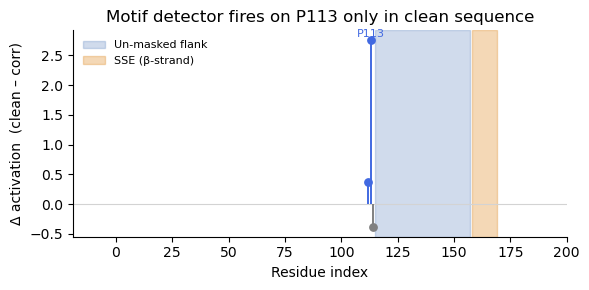

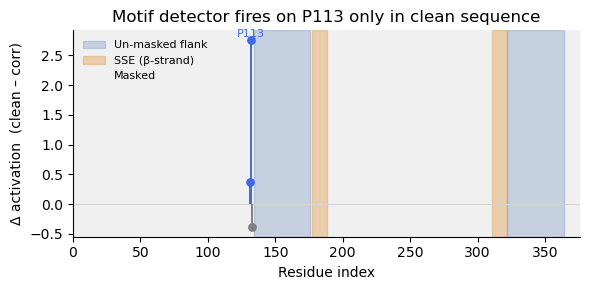

In [17]:
import matplotlib.patches as mpatches

# -------------------------------------------------
# variables you already have
# -------------------------------------------------
L              = len(seq)                 # full length
motif_pos      = 132                      # centre residue for P113
flank_left     = list(range(left_start,  left_end))     # clean left flank idxs
flank_right    = list(range(right_start, right_end))    # clean right flank idxs
sse1_span      = range(ss1_start, ss1_end + 1)
sse2_span      = range(ss2_start, ss2_end + 1)

# -------------------------------------------------
# plot frame
# -------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 3))

# 0)  masked (default) – light grey strip across the whole axis
ax.axvspan(0, L - 1, color="#f0f0f0", zorder=0)

# 1)  always-unmasked flanks (blue)
for span in (flank_left, flank_right):
    if span:
        ax.axvspan(span[0], span[-1], color="#4773b7", alpha=0.25, zorder=0)

# 2)  secondary-structure elements (orange)
for span in (sse1_span, sse2_span):
    ax.axvspan(span.start, span.stop - 1, color="#e0912f", alpha=0.35, zorder=0)

# 3)  baseline and lollipops (unchanged)
ax.hlines(0, 0, L - 1, color="lightgray", lw=0.8, zorder=1)
for xi, yi in zip(x, y):
    col = "royalblue" if yi > 0 else "gray"
    ax.vlines(xi, 0, yi, color=col, lw=1.4, zorder=2)
    ax.scatter(xi, yi, color=col, s=28, zorder=3)

# 4)  motif label
ax.text(motif_pos, delta[motif_pos] + 0.05, "P113",
        ha="center", fontsize=8, color="royalblue")

# 5)  aesthetics
ax.set_xlim(0, L - 1)
ax.set_xlabel("Residue index")
ax.set_ylabel("Δ activation  (clean – corr)")
ax.set_title("Motif detector fires on P113 only in clean sequence")
ax.spines[['right', 'top']].set_visible(False)

# legend — no in-panel text
handles = [
    mpatches.Patch(color="#4773b7",  alpha=0.25, label="Un-masked flank"),
    mpatches.Patch(color="#e0912f",  alpha=0.35, label="SSE (β-strand)"),
    mpatches.Patch(color="#f0f0f0",  alpha=1.00, label="Masked"),
]
ax.legend(handles=handles, frameon=False, fontsize=8, loc="upper left")

plt.tight_layout()
plt.savefig("panel_C_full.pdf")


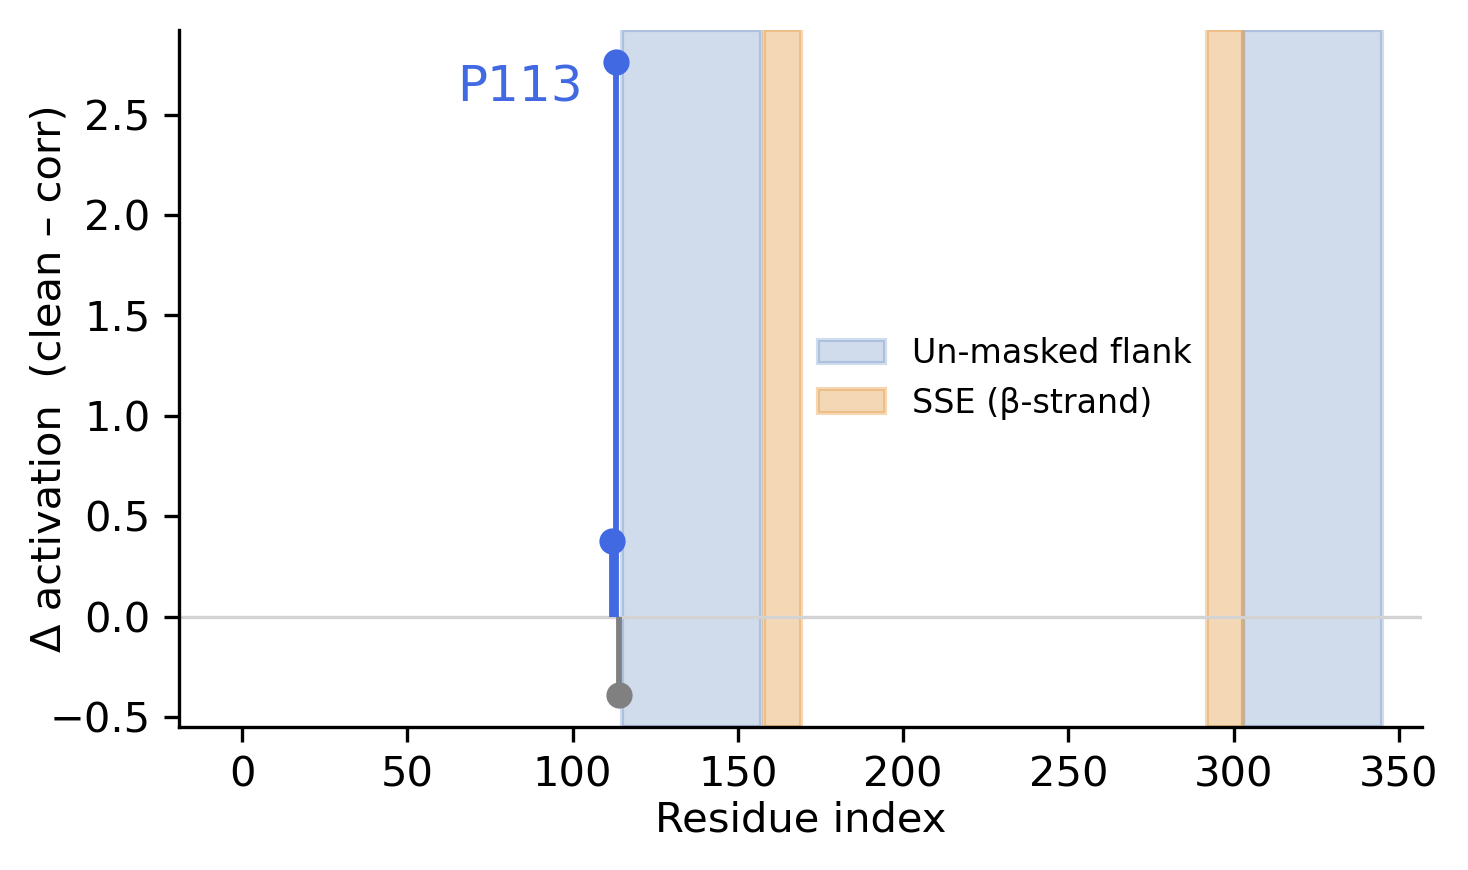

In [47]:
import matplotlib.patches as mpatches

offset = index_delta            # 19 in your example
L      = len(seq)               # full sequence length

# helper to shift all spans
def span(ax, start, end, **kw):
    ax.axvspan(start - offset, end - offset, **kw)

fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
ax.set_facecolor("white")       # kill any pink tint

# 1️⃣   always-unmasked flanks  (blue)
for span_idx in (flank_left, flank_right):
    if span_idx:
        span(ax, span_idx[0], span_idx[-1],
             color="#4773b7", alpha=0.25, zorder=0)

# 2️⃣   SSE (β-strands)         (orange)
for span_idx in (sse1_span, sse2_span):
    span(ax, span_idx.start, span_idx.stop - 1,
         color="#e0912f", alpha=0.35, zorder=0)

# 3️⃣   baseline and lollipops
ax.hlines(0, -offset, L - 1 - offset, color="lightgray", lw=0.8, zorder=1)
for xi, yi in zip(x, y):
    xi_shift = xi - offset
    col      = "royalblue" if yi > 0 else "gray"
    ax.vlines(xi_shift, 0, yi, color=col, lw=1.4, zorder=2)
    ax.scatter(xi_shift, yi, color=col, s=28, zorder=3)

# 4️⃣   motif label
ax.text(motif_pos - offset - 10, delta[motif_pos] - 0.2,
        "P113", ha="right", fontsize=12, color="royalblue")

# 5️⃣   axes & legend
ax.set_xlim(-offset, L - 1 - offset)
ax.set_xlabel(f"Residue index", labelpad=1) # (−{offset} shift)")
ax.set_ylabel("Δ activation  (clean – corr)", labelpad=-5)
# ax.set_title("Motif detector fires on P113\nonly in clean sequence")
ax.spines[['right', 'top']].set_visible(False)

handles = [
    mpatches.Patch(color="#4773b7", alpha=0.25, label="Un-masked flank"),
    mpatches.Patch(color="#e0912f", alpha=0.35, label="SSE (β-strand)")
]
ax.legend(handles=handles, frameon=False, fontsize=8, bbox_to_anchor=(0.49, 0.5), loc='center left')

plt.tight_layout()
plt.savefig("../results/panel_C_clean.pdf")
plt.savefig("../results/panel_C_clean.png")


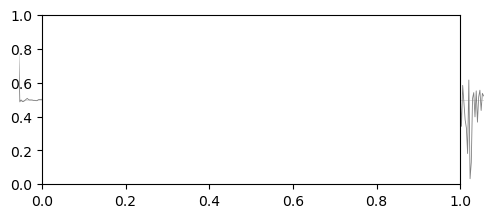

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax_full = plt.subplots(figsize=(6, 2.2))
ax_full.hlines(0, 0, len(delta)-1, color="lightgray", lw=0.5)
ax_full.plot(delta, lw=0.6, color="gray")              # thin line across seq
ax_full.set_xlim(0, len(delta)-1)
ax_full.set_ylim(-0.3, 0.3)                            # keeps it flat
ax_full.axis("off")                                    # minimalist

# highlight motif spike in full view
ax_full.scatter([motif_pos], [delta[motif_pos]], color="royalblue", s=15)

# inset: the lollipop zoom (reuse your lollipop code)
ax_zoom = inset_axes(ax_full, width="100%", height="100%",
                     bbox_to_anchor=(0.05, 0.0, 0.9, 1.0),
                     bbox_transform=ax_full.transAxes, borderpad=0)
# … run the same lollipop drawing commands on ax_zoom …

plt.savefig("panel_C_twin.pdf")
